# cnn모델-->정상/불량 예측

In [9]:
import os
import json
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# 이미지 크기 설정 (CNN 입력 크기)
IMG_SIZE = 224  

def load_data(img_dir, label_dir):
    X = []
    y = []

    for json_file in os.listdir(label_dir):
        if json_file.endswith(".json"):
            json_path = os.path.join(label_dir, json_file)
            with open(json_path, "r", encoding="utf-8") as f:
                data = json.load(f)

            # 정상 여부 (True: 정상, False: 불량) → 불량이면 1, 정상 0으로 변환
            label = int(data["image_info"]["is_normal"])

            # 이미지 파일명 가져오기
            img_name = data["image_info"]["file_name"]
            img_path = os.path.join(img_dir, img_name)

            # 이미지 로드 (컬러로 변경)
            if os.path.exists(img_path):
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # 컬러 (BGR)로 불러오기
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB 변환
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # CNN 입력 크기에 맞게 조정
                X.append(img)
                y.append(label)

    return np.array(X), np.array(y)

# 경로 설정
train_img_dir = r"C:\sample_ex3000\train\images"
train_label_dir = r"C:\sample_ex3000\train\labels"
val_img_dir = r"C:\sample_ex3000\val\images"
val_label_dir = r"C:\sample_ex3000\val\labels"
test_img_dir = r"C:\sample_ex3000\test\images"
test_label_dir = r"C:\sample_ex3000\test\labels"

# 데이터 다시 로드 (컬러 이미지)
X_train, y_train = load_data(train_img_dir, train_label_dir)
X_val, y_val = load_data(val_img_dir, val_label_dir)
X_test, y_test = load_data(test_img_dir, test_label_dir)

# CNN 입력 형태로 변환 (정규화 포함)
X_train = X_train / 255.0  # (2400, 224, 224, 3)
X_val = X_val / 255.0      # (300, 224, 224, 3)
X_test = X_test / 255.0    # (300, 224, 224, 3)

# 원-핫 인코딩
NUM_CLASSES = 2  
y_train = to_categorical(y_train, NUM_CLASSES)
y_val = to_categorical(y_val, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

# 변환된 데이터 크기 확인
print(f"변환 후 훈련 데이터 크기: {X_train.shape}, {y_train.shape}")
print(f"변환 후 검증 데이터 크기: {X_val.shape}, {y_val.shape}")
print(f"변환 후 테스트 데이터 크기: {X_test.shape}, {y_test.shape}")

변환 후 훈련 데이터 크기: (2400, 224, 224, 3), (2400, 2)
변환 후 검증 데이터 크기: (300, 224, 224, 3), (300, 2)
변환 후 테스트 데이터 크기: (300, 224, 224, 3), (300, 2)


C:\Users\enjoy\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 101s 660ms/step - accuracy: 0.9632 - loss: 0.2645 - val_accuracy: 0.7500 - val_loss: 0.4591
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 98s 653ms/step - accuracy: 0.9881 - loss: 0.0844 - val_accuracy: 0.9800 - val_loss: 0.1094
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 97s 650ms/step - accuracy: 0.9928 - loss: 0.0502 - val_accuracy: 0.4833 - val_loss: 3.4353
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 97s 647ms/step - accuracy: 0.9869 - loss: 0.0909 - val_accuracy: 0.9800 - val_loss: 0.1901
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 97s 646ms/step - accuracy: 0.9916 - loss: 0.0993 - val_accuracy: 0.9833 - val_loss: 0.1510
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 97s 644ms/step - accuracy: 0.9890 - loss: 0.0950 - val_accuracy: 0.9833 - val_loss: 0.1256
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 95s 634ms/step - accuracy: 0.9882 - loss: 0.0780 - val_accuracy: 0.9833 - val_loss: 0.1136


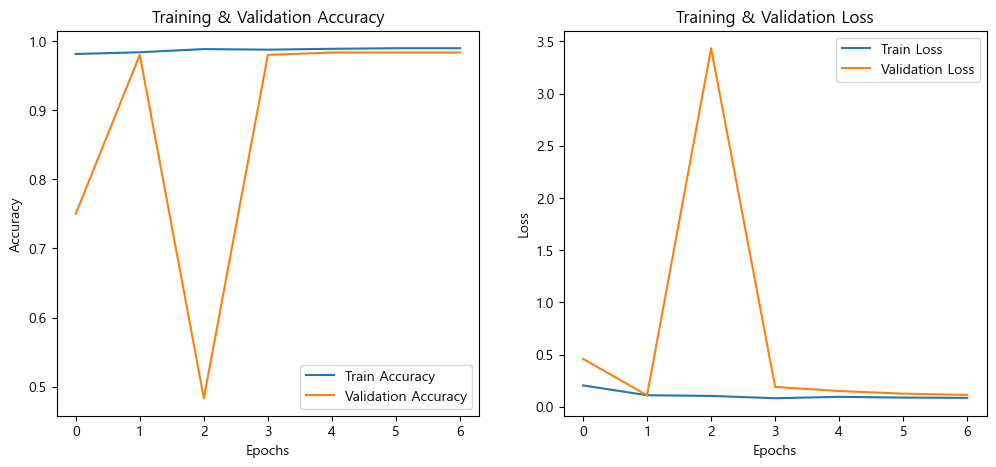

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# CNN 모델 구성
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),  
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # 이진 분류 (정상/불량)
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',  # 원-핫 인코딩을 적용했으므로 categorical_crossentropy 사용
              metrics=['accuracy'])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  
    batch_size=16,  
    callbacks=[early_stopping],
    verbose=1
)

# 학습 완료 후 모델 저장
model.save("battery_cnn_model.h5")

# 학습 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step
 테스트 데이터 성능 평가
정확도 (Accuracy): 0.9833
정밀도 (Precision): 0.9908
재현율 (Recall): 0.9643
F1-score: 0.9774


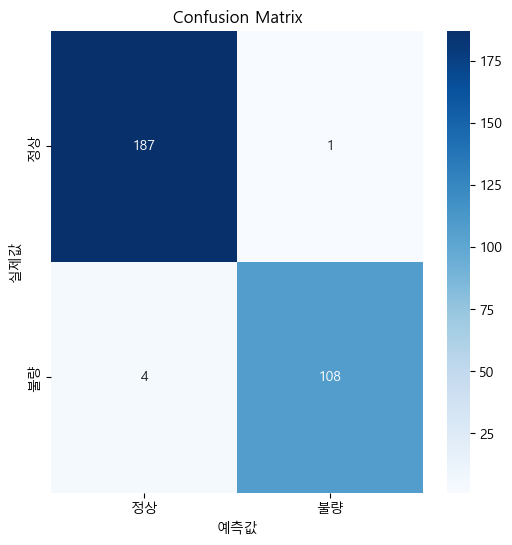

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# 테스트 데이터 예측
y_pred_prob = model.predict(X_test)  
y_pred = np.argmax(y_pred_prob, axis=1)  # 확률값을 클래스(0 or 1)로 변환
y_true = np.argmax(y_test, axis=1)  # 원-핫 인코딩을 원래 레이블로 변환

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f" 테스트 데이터 성능 평가")
print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"정밀도 (Precision): {precision:.4f}")
print(f"재현율 (Recall): {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# 혼동 행렬 (Confusion Matrix) 시각화
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["정상", "불량"], yticklabels=["정상", "불량"])
plt.xlabel("예측값")
plt.ylabel("실제값")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


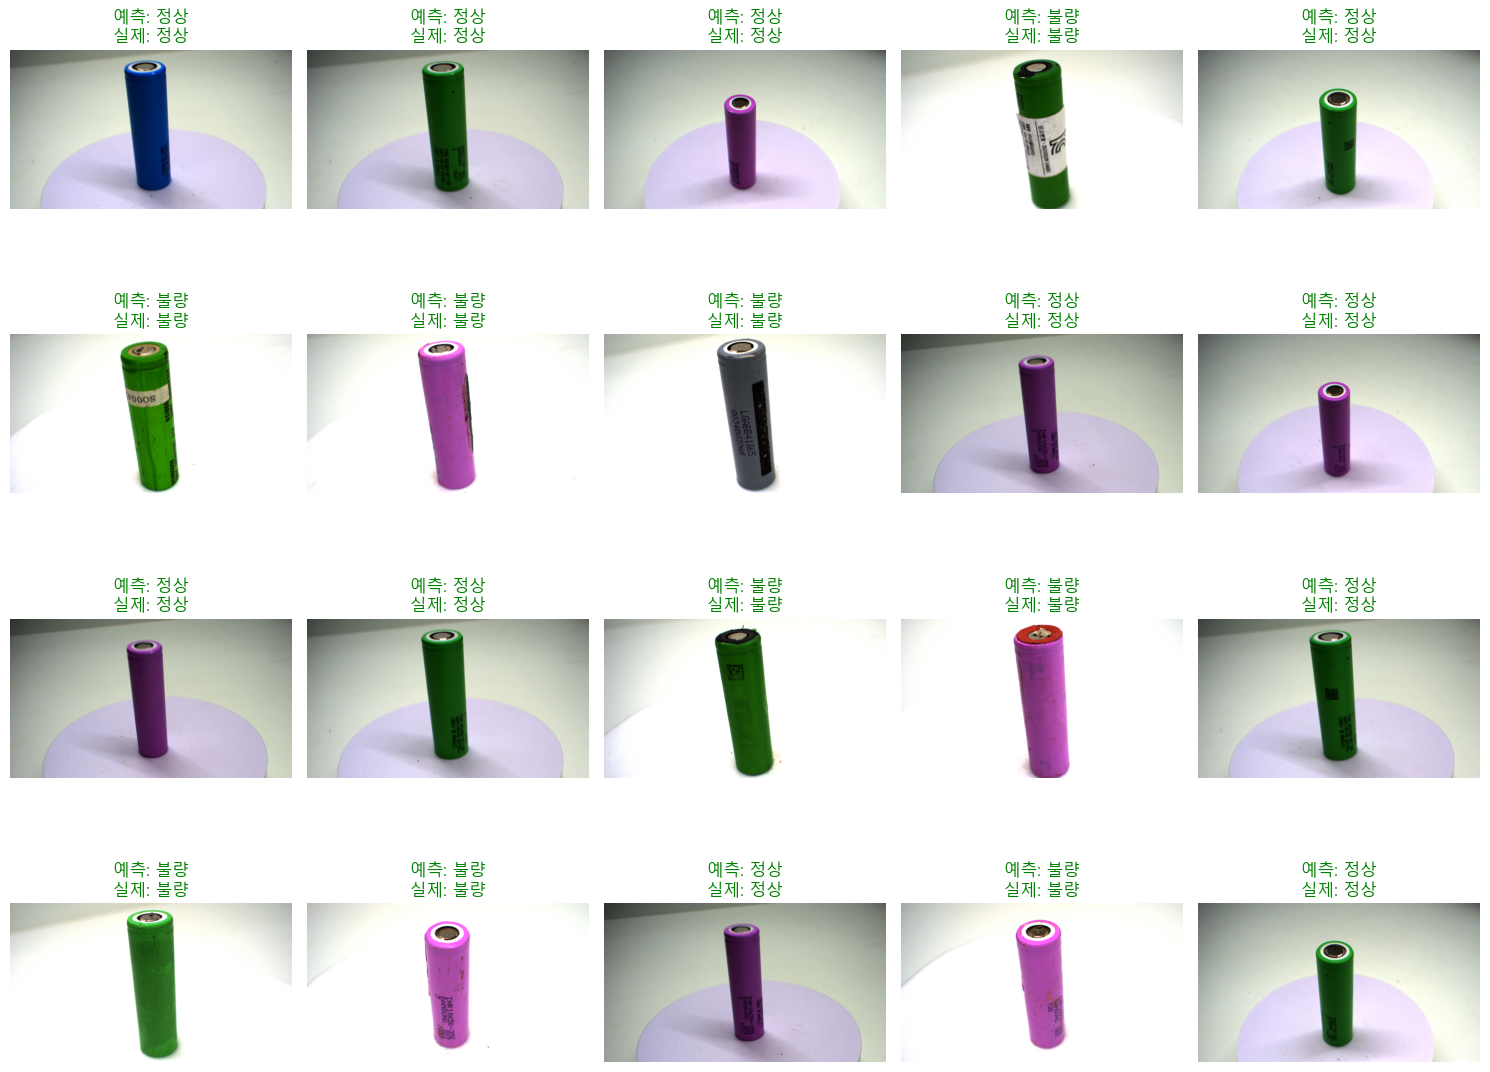

In [12]:
#테스트 이미지에서 정상/불량 예측
import os
import random
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (폰트 깨짐 방지)
plt.rc("font", family="Malgun Gothic")

# 테스트 이미지 & 라벨 경로
test_img_dir = r"C:\sample_ex3000\test\images"
test_label_dir = r"C:\sample_ex3000\test\labels"

# 랜덤 20개 이미지 선택
image_files = [f for f in os.listdir(test_img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
selected_images = random.sample(image_files, 20)

# 예측 및 시각화
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i, img_name in enumerate(selected_images):
    # 이미지 로드 & 전처리 (224x224로 리사이징)
    img_path = os.path.join(test_img_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환
    img_resized = cv2.resize(img, (224, 224)).astype(np.float32) / 255.0  

    # JSON 라벨 로드
    json_name = os.path.splitext(img_name)[0] + ".json"
    json_path = os.path.join(test_label_dir, json_name)

    if os.path.exists(json_path):
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        actual_label = "정상" if data["image_info"]["is_normal"] else "불량"
    else:
        actual_label = "알 수 없음"

    # 모델 예측
    img_input = np.expand_dims(img_resized, axis=0)  # (224, 224, 3) → (1, 224, 224, 3)
    pred_prob = model.predict(img_input)[0]  # 확률 예측
    pred_label = "정상" if np.argmax(pred_prob) == 1 else "불량"

    # 색상 설정 (틀린 경우 빨간색)
    pred_color = "green" if pred_label == actual_label else "red"

    # 결과 시각화
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].set_title(f"예측: {pred_label}\n실제: {actual_label}", fontsize=12, color=pred_color)
    axes[i // 5, i % 5].axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


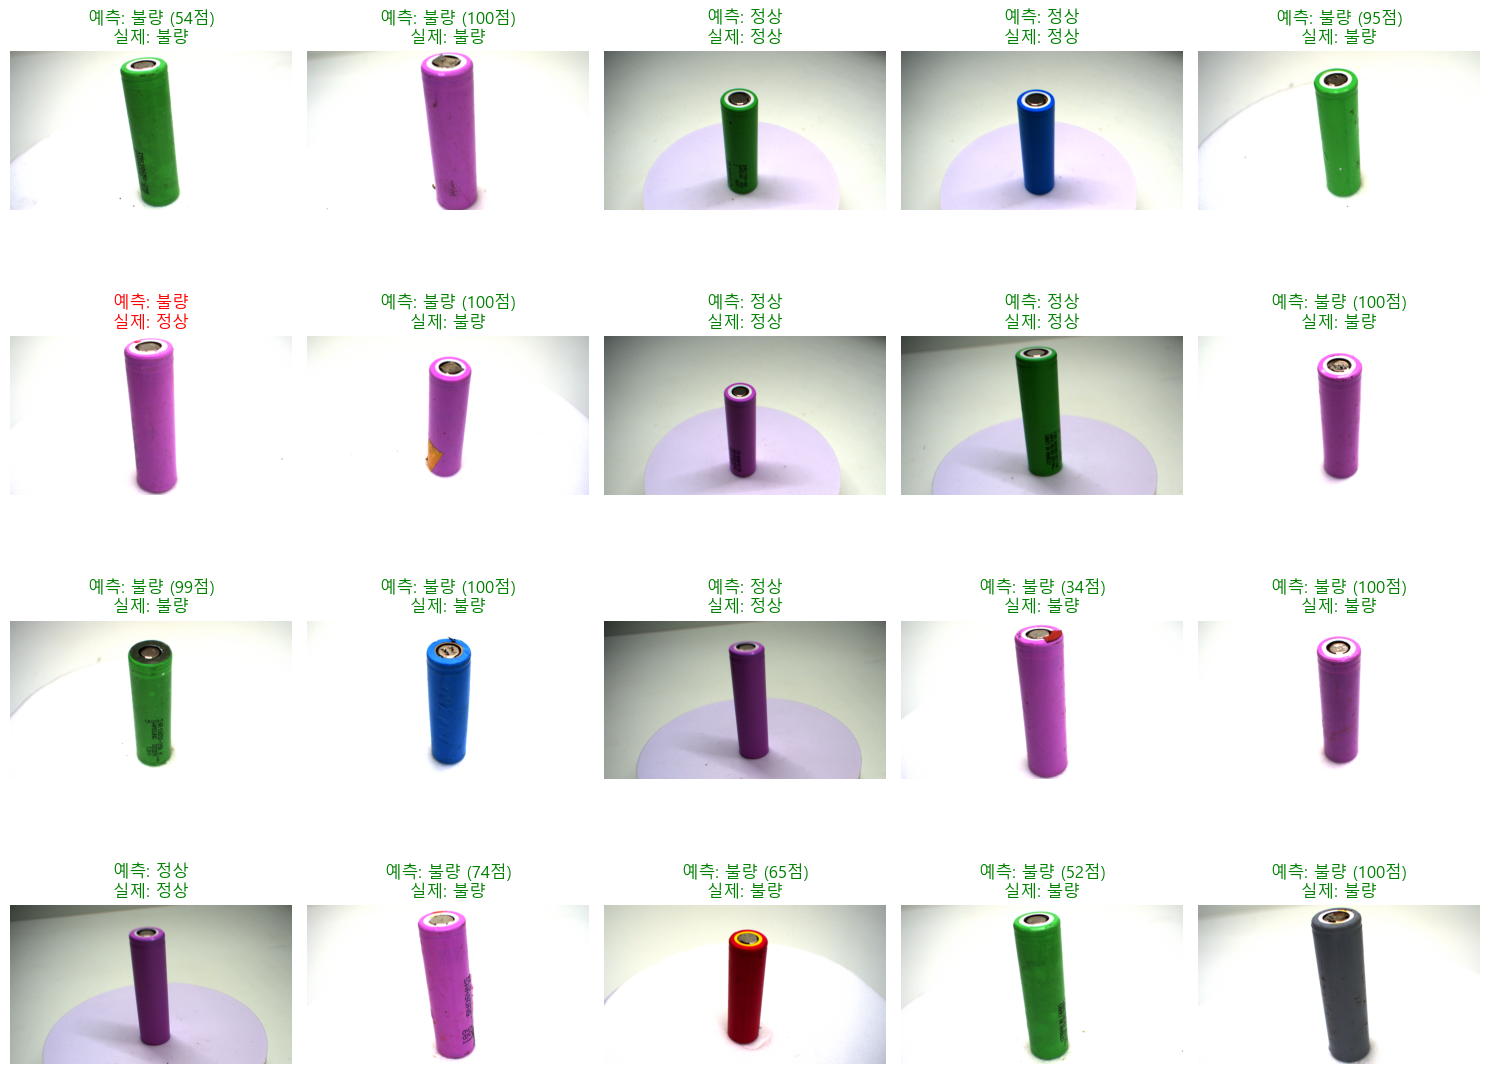

In [15]:
#불량 점수 적용
#점수 예시
# 불량개수	  불량 크기 (좌표 수)	    점수 (예상)
# 1개	       100~500	           10~30점 (경미한 불량)
# 2개	       500~1000	           30~50점 (중간 불량)
# 3개 이상	   1000 이상	       60~100점 (심각한 불량)
import os
import random
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rc("font", family="Malgun Gothic")

# 테스트 이미지 & 라벨 경로
test_img_dir = r"C:\sample_ex3000\test\images"
test_label_dir = r"C:\sample_ex3000\test\labels"

# 랜덤 20개 이미지 선택
image_files = [f for f in os.listdir(test_img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
selected_images = random.sample(image_files, 20)

# 예측 및 시각화
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i, img_name in enumerate(selected_images):
    # 이미지 로드 & 전처리 (224x224로 리사이징)
    img_path = os.path.join(test_img_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환
    img_resized = cv2.resize(img, (224, 224)).astype(np.float32) / 255.0  

    # JSON 라벨 로드
    json_name = os.path.splitext(img_name)[0] + ".json"
    json_path = os.path.join(test_label_dir, json_name)

    # 기본값 설정
    defect_score = 0  # 기본 점수는 0 (정상)
    actual_label = "알 수 없음"

    if os.path.exists(json_path):
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        # 실제 불량 여부 확인
        actual_label = "정상" if data["image_info"]["is_normal"] else "불량"

        # 불량 데이터 확인 (불량이 있는 경우 점수 부여)
        if not data["image_info"]["is_normal"] and "defects" in data and data["defects"] is not None:
            num_defects = len(data["defects"])  # 불량 개수
            total_area = sum(len(defect["points"]) for defect in data["defects"])  # 불량 크기 (좌표 수 기반)

            # 새로운 점수 계산 방식 (불량 개수 + 크기 기반, 스케일 조정)
            defect_score = num_defects * 10 + total_area // 20  
            defect_score = min(100, max(10, defect_score))  # 점수 범위를 10~100으로 제한

    # 모델 예측
    img_input = np.expand_dims(img_resized, axis=0)  # (224, 224, 3) → (1, 224, 224, 3)
    pred_prob = model.predict(img_input)[0]  # 확률 예측
    pred_label = "정상" if np.argmax(pred_prob) == 1 else "불량"

    # 색상 설정 (틀린 경우 빨간색)
    pred_color = "green" if pred_label == actual_label else "red"

    # 결과 시각화
    axes[i // 5, i % 5].imshow(img)
    if defect_score > 0:
        axes[i // 5, i % 5].set_title(f"예측: {pred_label} ({defect_score}점)\n실제: {actual_label}", fontsize=12, color=pred_color)
    else:
        axes[i // 5, i % 5].set_title(f"예측: {pred_label}\n실제: {actual_label}", fontsize=12, color=pred_color)
    axes[i // 5, i % 5].axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


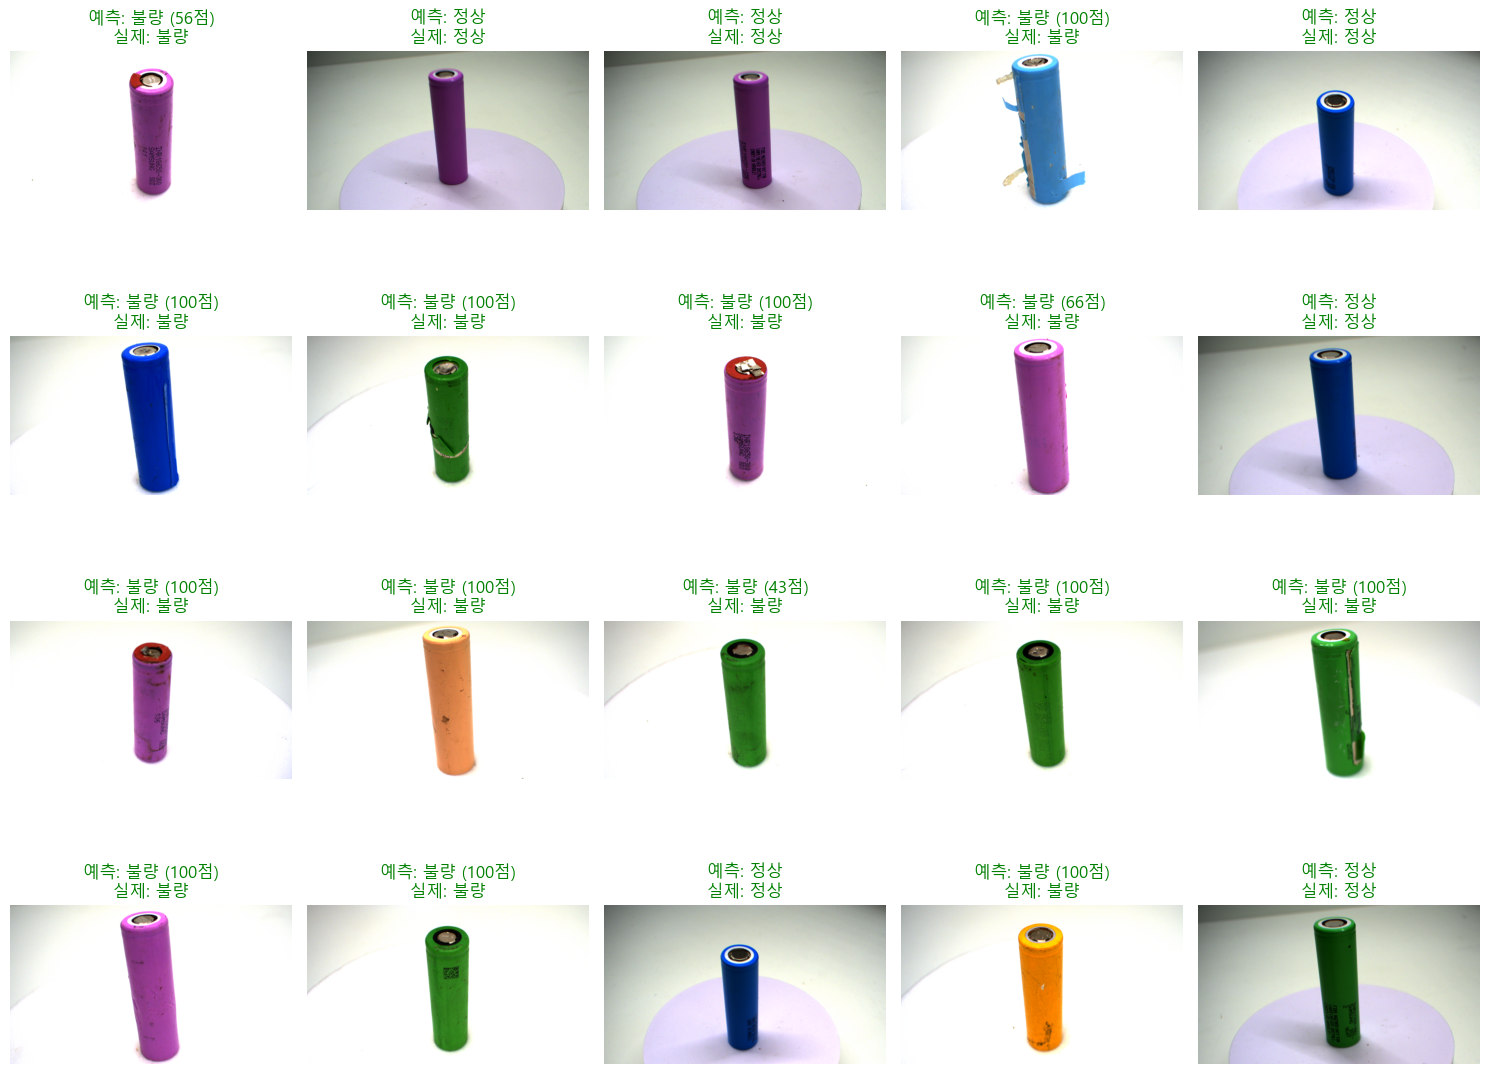

In [16]:
#위 코드와 같음
import os
import random
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rc("font", family="Malgun Gothic")

# 테스트 이미지 & 라벨 경로
test_img_dir = r"C:\sample_ex3000\test\images"
test_label_dir = r"C:\sample_ex3000\test\labels"

# 랜덤 20개 이미지 선택
image_files = [f for f in os.listdir(test_img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
selected_images = random.sample(image_files, 20)

# 예측 및 시각화
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i, img_name in enumerate(selected_images):
    # 이미지 로드 & 전처리 (224x224로 리사이징)
    img_path = os.path.join(test_img_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환
    img_resized = cv2.resize(img, (224, 224)).astype(np.float32) / 255.0  

    # JSON 라벨 로드
    json_name = os.path.splitext(img_name)[0] + ".json"
    json_path = os.path.join(test_label_dir, json_name)

    # 기본값 설정
    defect_score = 0  # 기본 점수는 0 (정상)
    actual_label = "알 수 없음"

    if os.path.exists(json_path):
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        # 실제 불량 여부 확인
        actual_label = "정상" if data["image_info"]["is_normal"] else "불량"

        # 불량 데이터 확인 (불량이 있는 경우 점수 부여)
        if not data["image_info"]["is_normal"] and "defects" in data and data["defects"] is not None:
            num_defects = len(data["defects"])  # 불량 개수
            total_area = sum(len(defect["points"]) for defect in data["defects"])  # 불량 크기 (좌표 수 기반)

            # 새로운 점수 계산 방식 (불량 개수 + 크기 기반, 스케일 조정)
            defect_score = num_defects * 10 + total_area // 20  
            defect_score = min(100, max(10, defect_score))  # 점수 범위를 10~100으로 제한

    # 모델 예측
    img_input = np.expand_dims(img_resized, axis=0)  # (224, 224, 3) → (1, 224, 224, 3)
    pred_prob = model.predict(img_input)[0]  # 확률 예측
    pred_label = "정상" if np.argmax(pred_prob) == 1 else "불량"

    # 색상 설정 (틀린 경우 빨간색)
    pred_color = "green" if pred_label == actual_label else "red"

    # 결과 시각화
    axes[i // 5, i % 5].imshow(img)
    if defect_score > 0:
        axes[i // 5, i % 5].set_title(f"예측: {pred_label} ({defect_score}점)\n실제: {actual_label}", fontsize=12, color=pred_color)
    else:
        axes[i // 5, i % 5].set_title(f"예측: {pred_label}\n실제: {actual_label}", fontsize=12, color=pred_color)
    axes[i // 5, i % 5].axis("off")

plt.tight_layout()
plt.show()